# numpyだけで実装するアルファベット26文字画像認識
<a5>フレームワークを一切使用せずnumpyで画像認識ニューラルネットワークを実装<br></a5>
<a5>データ：アルファベットA~Z(大文字小文字混合）<br>ラベル：アルファベット26種類（大文字小文字は分類しない）</a5>

In [1]:
"""
必要なライブラリをインポート
"""
# 公開ライブラリ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image
from sklearn.model_selection import train_test_split

# 自作ライブラリ
from libs.layers import TwoConvNet7
from libs.optimizer import RMSProp, Adam, Adadelta

## 画像データを用意する

(124800, 1, 28, 28)
(124800, 26)


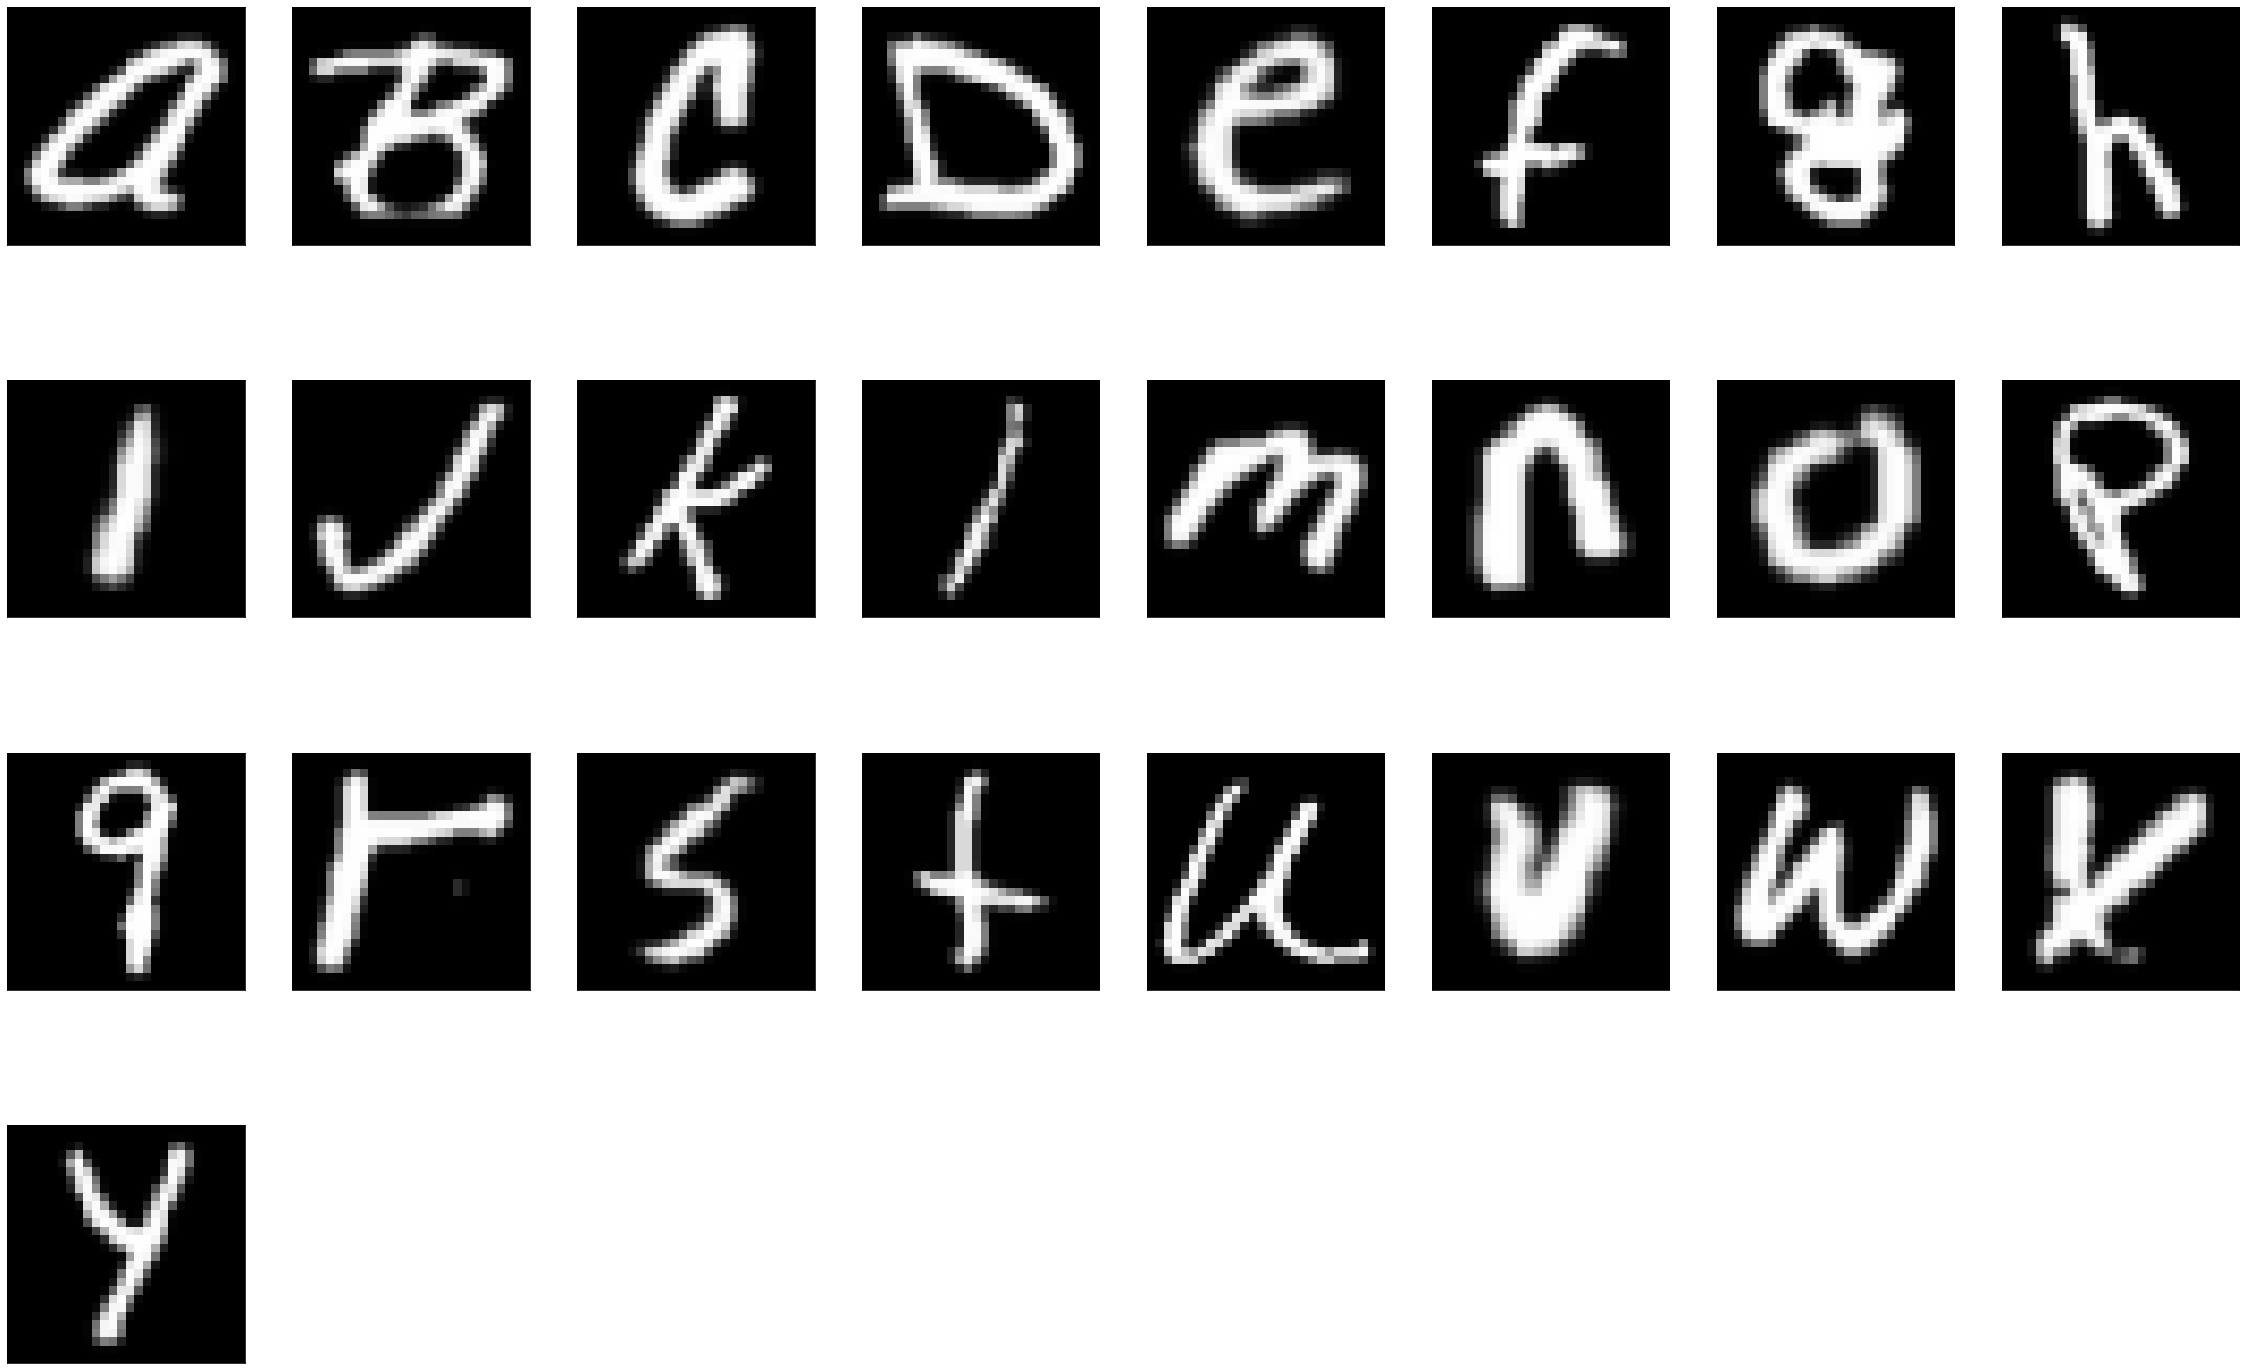

In [2]:
"""
emnistの読み込みと前処理
"""
# emnist 読み込み
# 今回はletters（アルファベット大文字A~Z + 小文字a~z）を対象
# ラベルは大文字、小文字の分類なし
from emnist import extract_training_samples, extract_test_samples
x_train_raw, y_train_raw = extract_training_samples("letters")
x_test_raw, y_test_raw = extract_test_samples('letters')

# 画像の前処理
img_side = 28
unique_classes = np.unique(y_train_raw)
num_classes = len(unique_classes)

#  labelsのOne-Hotベクトル化
y_train = y_train_raw - 1;
y_test = y_test_raw - 1;
y_test = np.identity(num_classes)[y_test]
y_train = np.identity(num_classes)[y_train]

# 白黒反転＋正規化
X_train = -(x_train_raw - 255) /255
X_test = -(x_test_raw - 255) / 255
X_train = X_train.reshape(-1,1,28,28)
X_test = X_test.reshape(-1,1,28,28)
print(X_train.shape)
print(y_train.shape)

# 学習する画像の表示
c = 1
plt.figure(figsize=(40, 40))
for i in range(0,10000):
    if c == y_train_raw[i]:
        ax = plt.subplot(6, 8, c)
        plt.imshow(x_train_raw[i].reshape(28, 28))
        plt.gray()
        #ax.plot()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        c = c + 1
        if c==num_classes:
            break
plt.show()

## 学習

In [3]:
#　エポック数とbatchサイズ
epochs =40
batch_size = 100

#　オプティマイザの設定
#　極小値付近では学習率を下げて微調整する
optimizer_Hi = Adam(lr=0.00005, rho1=0.99, rho2=0.999)
optimizer_Lo = Adam(lr=0.000003, rho1=0.99, rho2=0.999)

# 　イテレーション
xsize = X_train.shape[0]
iter_num = np.ceil(xsize / batch_size).astype(np.int)

#　NNのオブジェクト生成
#　VGGのような構成をした2層CNN
snet = TwoConvNet7(input_dim=(1, 28, 28), 
                 conv_param={'filter_num': 32, 'filter_size': 3, 'pad': 1, 'stride': 1},
                 conv_param2={'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 pool_param={'pool_size': 2, 'pad': 0, 'stride': 2},
                 pool_param2={'pool_size':2, 'pad':0, 'stride':2},
                 hidden_size=1024,
                 hidden_size2=128,
                 output_size=26,
                 weight_init_std=0.01, weight_decay_lambda = 0.01)

#　学習過程をログとして保存（デバッグ用）
import datetime
with open('./log.txt', 'a') as f:
    print("\n----------------------------------", file=f)
    print(datetime.datetime.now(), file=f)
    print("ネットワーク", file=f)
    for k, v in snet.params.items():
        print(k,v.shape, file=f)

        
#############
#　学習処理 #
#############
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
for epoch in range(epochs):
    print("epoch=%s"%epoch)
    
    #　エポックごとに取り出すデータのインデックスをシャッフルする
    idx = np.arange(xsize)
    np.random.shuffle(idx)

    for it in range(iter_num):
        # イテレーションごとにミニbatchを生成
        mask = idx[batch_size*it : batch_size*(it+1)]
        x_ = X_train[mask]
        y_ = y_train[mask]
        
        # 勾配の算出
        grads = snet.gradient(x_, y_, train_flg=True)

        # パラメータ更新
        if(epoch < 13):
            optimizer_Hi.update(snet.params, grads)
        else:
            optimizer_Lo.update(snet.params, grads)
            
    # 学習経過の記録
    # メモリエラーが発生するので500枚の画像に制限
    train_loss_val = snet.loss(X_train[:500],  y_train[:500])
    test_loss_val = snet.loss(X_test[:500], y_test[:500])
    train_acc_val = snet.accuracy(X_train[:500], y_train[:500])
    test_acc_val = snet.accuracy(X_test[:500], y_test[:500])
    
    print("train_loss: ", train_loss_val)
    print("test_loss: ",test_loss_val)
    print("train_acc: ",train_acc_val)
    print("test_acc_val: ",test_acc_val)
    
    # lossの記録
    print("calc accs")
    train_loss.append(train_loss_val)
    test_loss.append(test_loss_val)
    
    # 精度の記録
    train_accuracy.append(train_acc_val)
    test_accuracy.append(test_acc_val)
    
    # ログの書き込み
    with open('./log.txt', 'a') as f:
        print("エポック",epoch, file=f)
        print('train_loss : ', train_loss_val ,file=f)
        print('test_loss : ', test_loss_val ,file=f)
        print('train_acc : ', train_acc_val ,file=f)
        print('test_loss : ', test_acc_val ,file=f)

28
14
6272
14
7
3136
epoch=0
train_loss:  1.069588418766606
test_loss:  1.7703746920322212
train_acc:  0.832
test_acc_val:  0.714
calc accs
epoch=1
train_loss:  0.6320492674976141
test_loss:  0.889762529215359
train_acc:  0.88
test_acc_val:  0.87
calc accs
epoch=2
train_loss:  0.6158089105071578
test_loss:  0.6754381134017265
train_acc:  0.882
test_acc_val:  0.904
calc accs
epoch=3
train_loss:  0.626717567884678
test_loss:  0.8618316747066926
train_acc:  0.894
test_acc_val:  0.858
calc accs
epoch=4
train_loss:  0.6043786053263726
test_loss:  0.699858198543595
train_acc:  0.892
test_acc_val:  0.928
calc accs
epoch=5
train_loss:  0.5965737055690601
test_loss:  0.6905515483573205
train_acc:  0.918
test_acc_val:  0.922
calc accs
epoch=6
train_loss:  0.5768832963370006
test_loss:  0.6094556258377595
train_acc:  0.92
test_acc_val:  0.948
calc accs
epoch=7
train_loss:  0.5609959307387149
test_loss:  0.6490732930434072
train_acc:  0.918
test_acc_val:  0.932
calc accs
epoch=8
train_loss:  0.546

# 学習結果
<a5>最高精度 96.4% <br>
参考：標準なmnist（手書き数字0~9）で同じモデルで学習した時、最高精度が99.1%</a5>
<a5>ただし一部のデータでの精度なので、データに偏りの可能性あり。<br>
    batchごとに精度を算出し平均化した精度を別ブックで確認する。</a5>

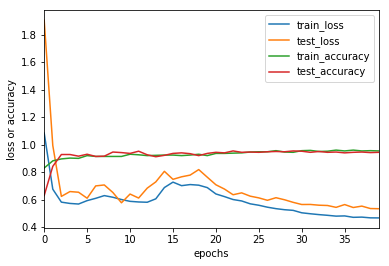

In [4]:
# 学習過程の可視化
df_log = pd.DataFrame({"train_loss":train_loss,
             "test_loss":test_loss,
             "train_accuracy":train_accuracy,
             "test_accuracy":test_accuracy})
df_log.plot()
plt.ylabel("loss or accuracy")
plt.xlabel("epochs")
plt.show()

# モデルの保存

In [4]:
with open("model.pickle", "wb") as f:
    pickle.dump(snet, f)

# 考察
<a5>mnistに対して分類が増えた分、学習が困難になると思っていたが、想定以上の精度になった。<br>精度向上にはパラメータ数を増やすことで表現力を豊かにしたことが一番貢献したと思う。numpyですべて実装しGPUが一切利用できないため学習に時間を要した。RAM不足でbatchサイズや精度算出に制限があったので、リソースがある環境で試せばもっと改善ができる余地はあるはず。</a5>
<a5>大文字小文字を同じラベルで分類できるのは恐らく共通の特徴をうまく拾えているからだと思う。（例：ｔとＴは横と縦の線で構成されているなど）<br>今後、フィルタを可視化してどこに注目しているか確認してみる必要がある。</a5>